**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

# reading data from lesson 2
df_raw = pd.read_feather('tmp/bulldozers-raw')
# fill in missing values, convert cats to nums, pull out target (dependent variable)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

print(df_trn.shape)
print(y_trn.shape)
nas # keys - numeric cols with missing values, values are the medians

(401125, 66)
(401125,)


{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [ ]:
??is_numeric_dtype

**Note**:

`nas` is a dictionary of the columns (the keys) which had missing values and the medians (the values) for each of those columns.

You can pass `nas` to `proc_df` (3rd arg) when pre-processing your test dataset to ensure it uses those same median values in those columns for any missing values.

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid

# split the data into training and validation data sets
X_train, X_valid = split_vals(df_trn, n_trn) # data
y_train, y_valid = split_vals(y_trn, n_trn) # labels
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
X_train.sample(5).T

(389125, 66) (12000, 66) (389125,) (12000,)


,155897,61906,219717,28317,244808
SalesID,1550060,1326929,1688492,1259085,1754110
MachineID,825750,1089476,1303537,1203167,1302417
ModelID,7026,1526,22982,6633,349
datasource,132,132,132,132,132
auctioneerID,10,9,1,2,1
YearMade,2003,1984,1995,1000,1000
MachineHoursCurrentMeter,0,0,0,0,0
UsageBand,-1,-1,-1,-1,-1
fiModelDesc,396,2096,2742,184,3710
fiBaseModel,136,681,851,63,1381


In [6]:
# helper functions
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [
        rmse(m.predict(X_train), y_train), 
        rmse(m.predict(X_valid), y_valid),
        m.score(X_train, y_train), 
        m.score(X_valid, y_valid)
    ]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [7]:
# set the number of sample the random forest will use to train the model
# big enough that if the model is run multiple times, you don't get diff results
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(
    n_estimators=40, 
    min_samples_leaf=3, 
    max_features=0.5, 
    n_jobs=-1, 
    oob_score=True
)
m.fit(X_train, y_train)
print_score(m)

[0.20579251998820647, 0.24844982355459894, 0.9114896625315295, 0.8897635143860112, 0.8945100675467156]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [9]:
# go through each estimator (model) on our 'forest', calling 'predict' on it
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])

# grab the first prediction and compute the mean and std for one observation
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 2.24 s, sys: 44 ms, total: 2.29 s
Wall time: 2.29 s


(9.31005166413849, 0.3805665425650151)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [9]:
# Python is single threaded, running on a single core
# 'parallel_trees' fastai func that parallizes the func that is passed
# it takes a random forest (1st arg) and a function to call (2nd arg)
# returns a list of the predictions
def get_preds(t): 
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
print(preds.shape) # 40 estimators, 1 pred from each
print()
print(preds)
print()
print(preds[:, 0]) # 40 rows, 1st column
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 104 ms, sys: 92 ms, total: 196 ms
Wall time: 1.11 s
(40, 12000)

[[9.30364 9.23367 9.08111 ... 9.29442 9.04212 9.04212]
 [9.06687 9.24108 9.4172  ... 9.10084 9.43338 9.43338]
 [9.3255  9.07476 9.37483 ... 9.87761 9.47435 9.47435]
 ...
 [9.15428 8.99436 9.15428 ... 9.678   9.34826 9.34826]
 [9.05692 9.0061  9.05507 ... 9.28131 9.08374 9.08374]
 [9.23807 9.38422 9.21425 ... 9.3194  9.32047 9.32047]]

[9.30364 9.06687 9.3255  9.16252 9.1668  9.00936 9.35728 9.37768 9.07476 9.41287 9.15296 9.07505 9.31314
 9.28797 9.10333 9.28285 9.09826 9.10421 9.82838 8.94086 9.53526 9.80957 8.98607 8.99555 9.57661 9.37606
 8.9421  9.50792 9.07485 9.01703 9.40443 9.34738 9.11164 9.07485 9.16789 8.96668 9.28239 9.15428 9.05692
 9.23807]


(9.226746914992223, 0.21424047716416608)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

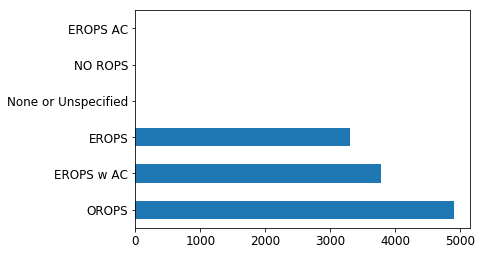

In [12]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [13]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.836897,0.279585
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.581425,0.260987
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682715,0.227470


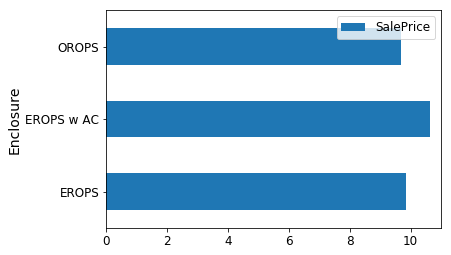

In [14]:
# plot the sale price for each level of enclosure
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

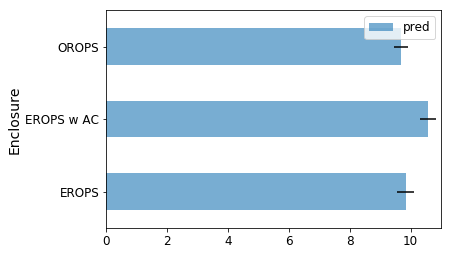

In [15]:
# plot the prediction for each level of enclosure, error bars (confidence interval)
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

**This will tell us if there are any groups or rows that we are not confident of**.

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

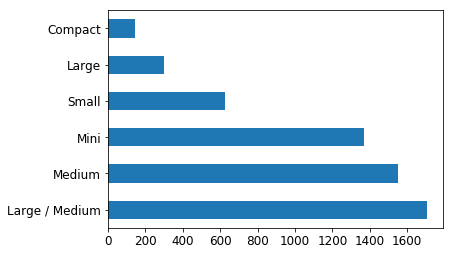

In [16]:
# repeating the process for product size
raw_valid.ProductSize.value_counts().plot.barh();

In [17]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.847701,0.346310
Large,10.470589,10.386108,0.355299
Large / Medium,10.691871,10.648355,0.292468
Medium,10.681511,10.623671,0.282710
Mini,9.535147,9.568535,0.255876
Small,10.324448,10.317194,0.301994


We can calculate the ratio of the standard deviations of the predictions to the predictions themselves (we expect on average that when you are predicting something that is a bigger number, that your std would be bigger) - the ratios should be approx. the same.

In [18]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035167
Large             0.034209
Small             0.029271
Large / Medium    0.027466
Mini              0.026741
Medium            0.026611
dtype: float64

We can see that our predictions for `Large` and `Compact` are less accurate. We can see from the histogram that they are the smallest groups - with smaller groups the estimators are doing a poorer job of predicitions since they have fewer examples to train on.

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

You want to build a random forest as quickly as possible, even if it is only just better than average (baseline model) - to determine which are the columns which matter.

The `fastai` library has the `rf_feat_importance` function which takes a random forest model (train 1st) and dataframe and returns a dataframe with the columns in order of importance.

In [10]:
# returns a list of the columns in order of importance
fi = rf_feat_importance(m, df_trn);
print(fi.shape)
fi[:10] 

(66, 2)


,cols,imp
5,YearMade,0.173722
37,Coupler_System,0.107351
13,ProductSize,0.104697
14,fiProductClassDesc,0.077156
2,ModelID,0.059195
63,saleElapsed,0.050873
10,fiSecondaryDesc,0.047011
38,Grouser_Tracks,0.041073
39,Hydraulics_Flow,0.038892
19,Enclosure,0.034381


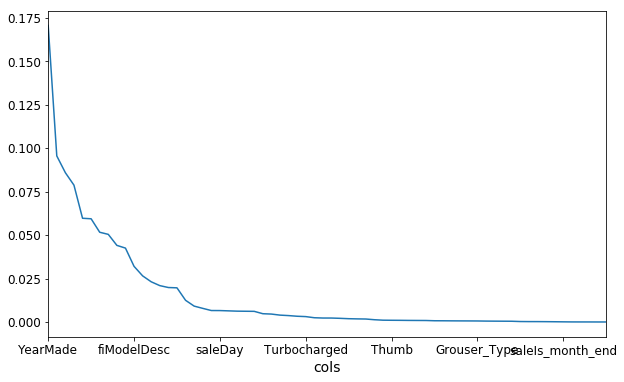

In [20]:
# plot of feature importance vs columns
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

We can see that some columns are really important, e.g. `YearMade`, while many are of little to no importance. Means you can focus on the columns which matter.

In [11]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

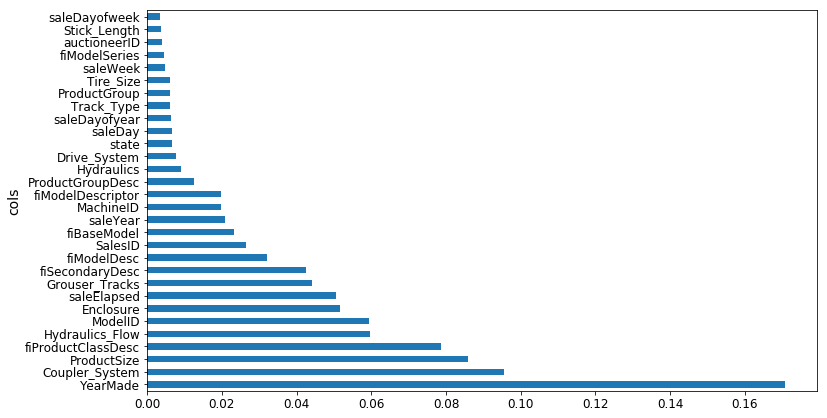

In [22]:
plot_fi(fi[:30]); # plot the top 30 cols

In [23]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,20), legend=False)

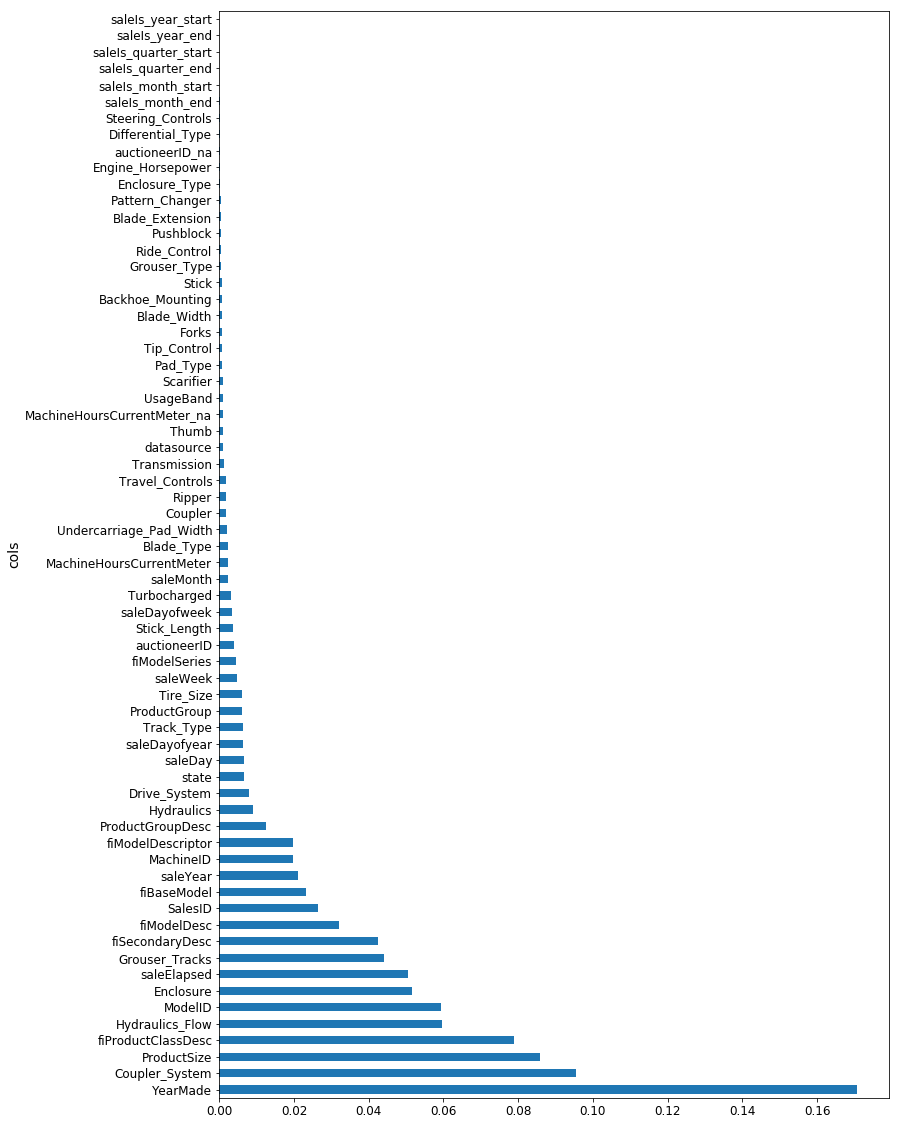

In [24]:
# plotting all columns
plot_fi(fi)

In [12]:
# filter out any columns where imp <= 0.005 (where the results flatten off)
to_keep = fi[fi.imp > 0.005].cols;
print('num cols remaining:', len(to_keep))
print(to_keep)

num cols remaining: 24
5               YearMade
37        Coupler_System
13           ProductSize
14    fiProductClassDesc
2                ModelID
63           saleElapsed
10       fiSecondaryDesc
38        Grouser_Tracks
39       Hydraulics_Flow
19             Enclosure
8            fiModelDesc
0                SalesID
9            fiBaseModel
51              saleYear
12     fiModelDescriptor
1              MachineID
16          ProductGroup
35             Tire_Size
30            Hydraulics
17      ProductGroupDesc
18          Drive_System
54               saleDay
15                 state
56         saleDayofyear
Name: cols, dtype: object


Create a dataframe with just those columns, and split into training and validation sets.

In [13]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn) # split into train and val sets

We'll train a new model with the 'important columns.

In [27]:
m = RandomForestRegressor(
    n_estimators=40, 
    min_samples_leaf=3, 
    max_features=0.5,
    n_jobs=-1, 
    oob_score=True
)
m.fit(X_train, y_train)
print_score(m)

[0.206904895525504, 0.2453207009354764, 0.9105302221247833, 0.8925227940309107, 0.8942705570591046]


Very slight improvement in R^2 (0.892 vs 0.889).

When removing redundant cols, you also remove sources of co-linearity, i.e' two cols that might be related to each other. Results in making your feature plot clearer - gives you a better picture of which columns are important.

In [11]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

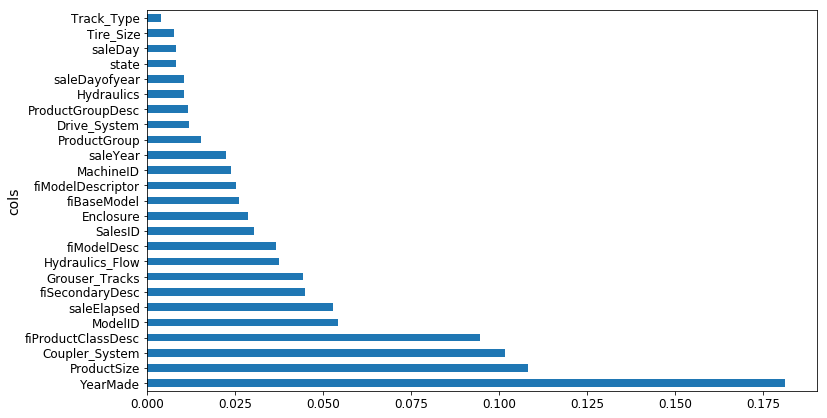

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Using `rf_feature_importance` is a technique that you can use for almost any model.

It determines the impact of each column (feature) on the accuracy of predictions (R^2 and RMSE) by taking each column in turn and:

* shuffle that particular column, carry out the predictions, calculate R^2/RMSE and determine the difference with the original scores.
* repeat the process for each column, returning a dataframe with the features in the order of importance.

With this knowledge you now want to:

* find out what you can about each variable, plot it's histogram, create a scatterplot of it vs the target variable.
* do any appear to have a lot of 'noise'
* are any of the variables high cardinality categorical which could be split into multiple columns.

### Overfitting and Hyperparamter Tuning in Random Forests.

The most important hyperparamters (the are others, check the docs) are:

`set_rf_samples` (20-50k) - sets the size of the subset of ssamples used to train the estimators. Thus a subset size of 20k results in a tree of depth `log2(20k)` and 20k leaf nodes (there is a linear relationship between sample size and number of leaf nodes). By reducing `set_rf_samples` we reduce the trees predictive ability, but by reducing the trees depth (and consequently the models complexity) we reduce overfitting. Overcome trees reduced predictive ability by using **bagging** - create lots of trees, which are not correlated so any errors are canceled out.

`min_samples_leaf` (1, 3, 5, 10, 30, 100) - sets the depth of the tree. `min_samples_leaf=1` creates a tree of max depth, leaf nodes with one sample. A value of `2` stops when when the leaf node has 2 samples (unless all the samples are the same in that node for the dependent variable, in which case there is no point in spliting further as no further information will be added). Every doubling of the `min_samples_leaf` removes one layer from the tree and halves the number of leaf nodes. Increasing `min_sample_leaf` will result in a reduction in the predictive accuracy of our model and correlation across our estimators, but reduce overfitting.

`max_features` (None, 0.5, sqrt, log2) - by default, all features are used at each split. In situations when using a small number of estimators, e.g. 10, and one feature which is 'highly predicitive', can result in trees where every split is on the same feature, resulting in trees which are very similar. Setting `max_features=0.5` means that each split (decision point) is made on a different half of the features. The overall effect is more varied trees, but less accurate.

## One-hot encoding

`proc_df`'s optional *max_n_cat* argument will turn some categorical variables into new columns.

Note: to implement **one-hot-encoding** with `proc_df`, set the `max_n_cat` attribute. The valueis the number of cols to create. Any categorical variable with a greater number of unique values will NOT be converted, but be left as a number.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [30]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20713996040011204, 0.25246944966435914, 0.9103268132218697, 0.8861676659808335, 0.8926231357906164]


There is a slight improvement in `RMSE`, `R^2` and `oob` scores when compared to before, [0.206904895525504, 0.2453207009354764, 0.9105302221247833, 0.8925227940309107, 0.8942705570591046].

In addition different fetaures have become important.

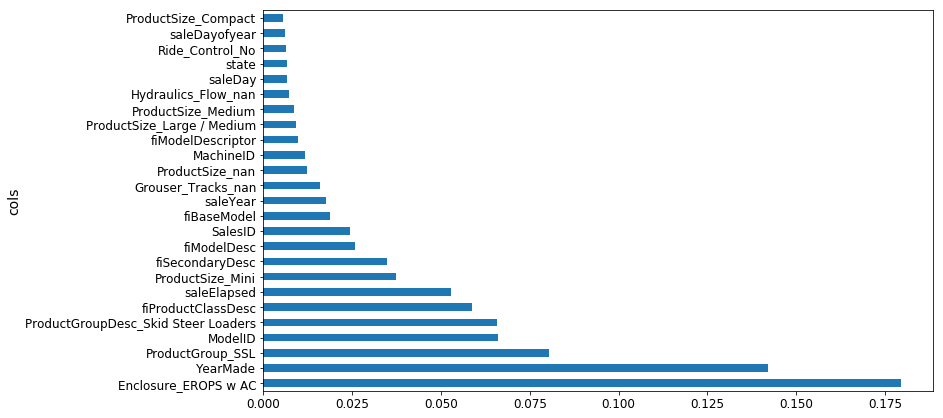

In [31]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features using a **dendrogram** - a form of **cluster analysis**.

With cluster analysis you look at objects, either rows or columns, and find which are similar to each other - measuring the same thing and remove them.

In [33]:
from scipy.cluster import hierarchy as hc

Create **dendogram**, distance measure is based on **Rank Correlation**.

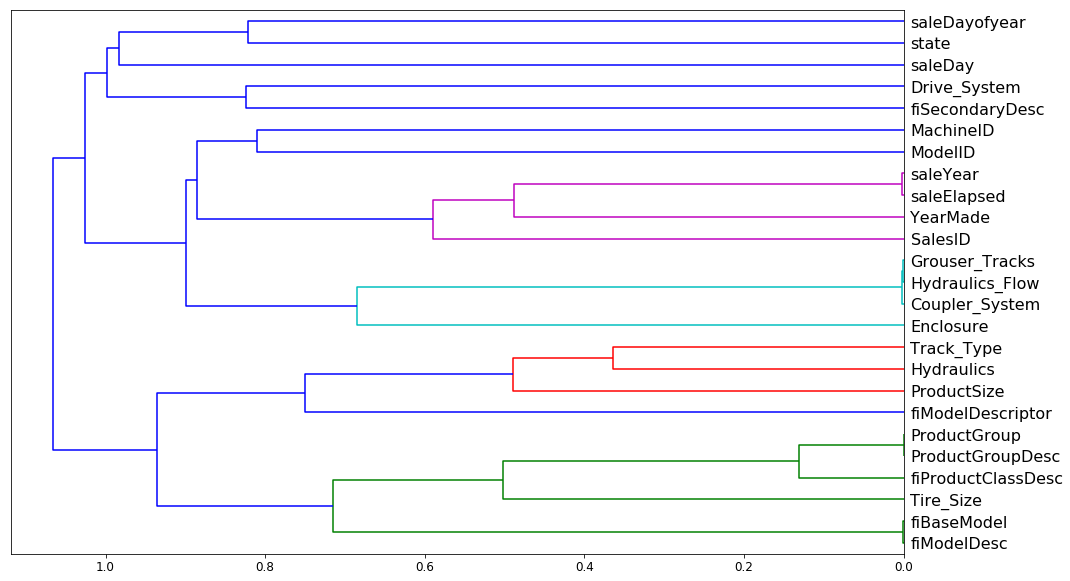

In [34]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

We can see that `saleYear` and `saleElapsed` are measuring the same thing, as are `ProductGroup` and `ProductGroupDesc`.

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [35]:
def get_oob(df):
    m = RandomForestRegressor(
        n_estimators=30, 
        min_samples_leaf=5, 
        max_features=0.6, 
        n_jobs=-1, 
        oob_score=True
    )
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [37]:
get_oob(df_keep)

0.890030754497739

Now we try removing each variable one at a time - repeat the model training and scoring, removing one of the columns on each iteration and recording the `oob_score`.

In [38]:
for c in (
    'saleYear', 
    'saleElapsed', 
    'fiModelDesc', 
    'fiBaseModel', 
    'Grouser_Tracks', 
    'Hydraulics_Flow', 
    'Coupler_System',
    'ProductGroup',
    'ProductGroupDesc'
):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8893117220536251
saleElapsed 0.8869423229716659
fiModelDesc 0.8888961809611584
fiBaseModel 0.8889007713808725
Grouser_Tracks 0.8902466567255374
Hydraulics_Flow 0.8903733978560141
Coupler_System 0.8899211583961898
ProductGroup 0.8900719325514128
ProductGroupDesc 0.8902492905462155


The `oob_score` are approx. the same for each member of group - we can try and remove one from each group. Re-train and score the model having dropped the columns and checkthe `oob_score`.

In [40]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks', 'Hydraulics_Flow', 'ProductGroupDesc']
get_oob(df_keep.drop(to_drop, axis=1))

0.8895860095697606

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [41]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [42]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [43]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [44]:
df_keep.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'Enclosure', 'saleElapsed', 'fiSecondaryDesc', 'fiModelDesc',
       'SalesID', 'MachineID', 'fiModelDescriptor', 'Hydraulics',
       'Drive_System', 'state', 'saleDay', 'saleDayofyear', 'Track_Type',
       'ProductGroup', 'Tire_Size'],
      dtype='object')

In [46]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 20 columns):
YearMade              401125 non-null int64
Coupler_System        401125 non-null int8
ProductSize           401125 non-null int8
fiProductClassDesc    401125 non-null int8
ModelID               401125 non-null int64
Enclosure             401125 non-null int8
saleElapsed           401125 non-null int64
fiSecondaryDesc       401125 non-null int16
fiModelDesc           401125 non-null int16
SalesID               401125 non-null int64
MachineID             401125 non-null int64
fiModelDescriptor     401125 non-null int16
Hydraulics            401125 non-null int8
Drive_System          401125 non-null int8
state                 401125 non-null int8
saleDay               401125 non-null int64
saleDayofyear         401125 non-null int64
Track_Type            401125 non-null int8
ProductGroup          401125 non-null int8
Tire_Size             401125 non-null int8
dtypes: int16(3), i

In [45]:
df_keep.head()

,YearMade,Coupler_System,ProductSize,fiProductClassDesc,ModelID,Enclosure,saleElapsed,fiSecondaryDesc,fiModelDesc,SalesID,MachineID,fiModelDescriptor,Hydraulics,Drive_System,state,saleDay,saleDayofyear,Track_Type,ProductGroup,Tire_Size
0,2004,0,0,59,3157,3,1163635200,41,950,1139246,999089,0,1,0,1,16,320,0,6,17
1,1996,0,4,62,77,3,1080259200,55,1725,1139248,117657,0,1,0,33,26,86,0,6,12
2,2001,1,0,39,7009,6,1077753600,0,331,1139249,434808,0,4,0,32,26,57,0,3,0
3,2001,0,6,8,332,3,1305763200,0,3674,1139251,1026470,0,1,0,44,19,139,0,4,0
4,2007,1,0,40,17311,1,1248307200,0,4208,1139253,1057373,0,4,0,32,23,204,0,3,0


And let's see how this model looks on the full dataset.

In [47]:
reset_rf_samples()

In [48]:
m = RandomForestRegressor(
    n_estimators=40, 
    min_samples_leaf=3, 
    max_features=0.5, 
    n_jobs=-1, 
    oob_score=True
)
m.fit(X_train, y_train)
print_score(m)

[0.1250722836757535, 0.2280900776227126, 0.9673068335674837, 0.9070903637031241, 0.9086021895355618]


Original scores:

[0.206728428343962, 0.2497536196498307, 0.9106827728565976, 0.8886034973301882, 0.8935122171810368]

We've removed columns which had no value and those that we're related to other columns and added no extra value (duplicate features) - resulted in a simpler model, which also producing better scores (RMSE down, R^2 up and oob_score down).

# Partial dependence

For the features tha are important, how do they relate to the dependent variable.

In [14]:
from pdpbox import pdp
from plotnine import *

In [15]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [16]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

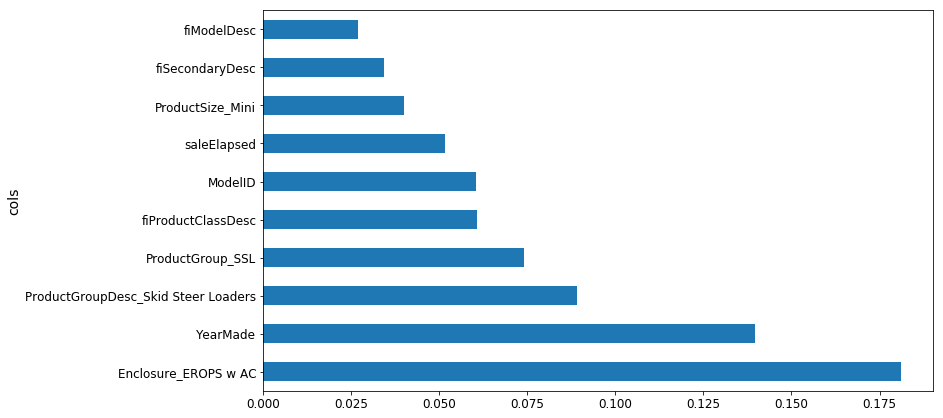

In [17]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

`YearMade` and `saleElapsed` will give us some idea to the age of the item when sold, so we would expect them to be related in some way. We'll thus plot one against the other in a scatter plot.

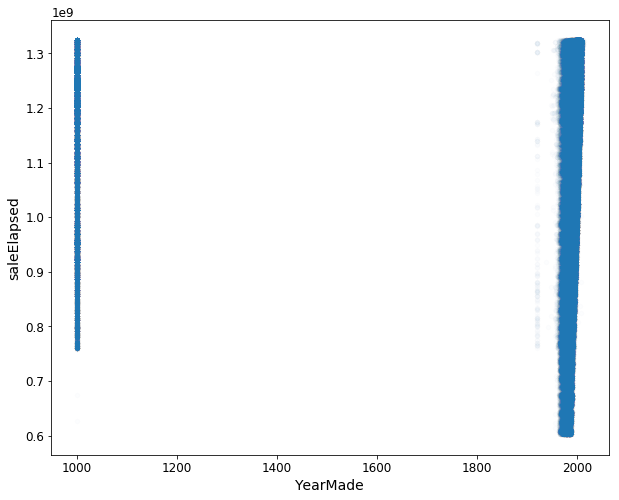

In [18]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

Clearly bulldozers were not made in the year `1000`. We need to talk to the client, it's probable that `YearMade` was not being tracked at the time, and a dummy value was used.

To work around this, we'll get all rows with `YearMade` after 1930.

In [19]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500) # grab a random 500 samples from df

`ggplot` is a port of the R graphics package of the same name. It has the same api as the R version so use that versions docs for help! The grey area around the line is the confidence interval.

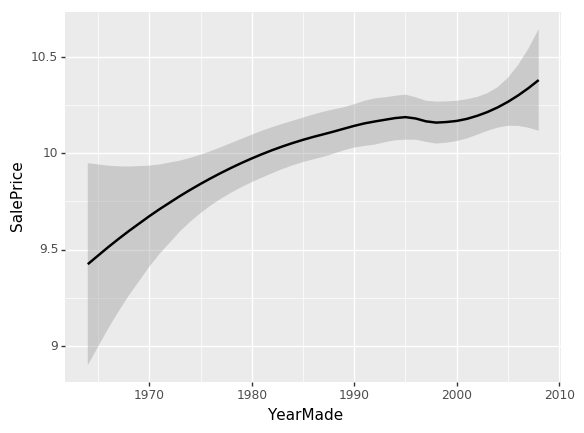

<ggplot: (-9223363299944452846)>

In [20]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

We can see that between 1990-97 prices dropped. Why? We would expect the relationship to be linear.

There is obviously some other factor involved, recession, promotion, etc. There are a lnumber of interactions (co-linearity) going on that this graph does not show. 

The problem with looking a **univariant** analyses like these is that it does not show the cause of any unexpected plot. 

We want to know what is the relationship between `SalePrice` and `YearMade` all other things being equal (excluded). To do so we can create a **partial dependene plot**. For each of the 500 samples, we'll calculate what the item would have sold for if it were sold in 1960, we'll then repeat that for 1961, 1962 and so on. We'll then calculate the average which will show the relationship between `YearMade` and `SalePrice` - which produces a straight line. Which is what we would expect. We expect newer vehicles to be more expensive because of inflation. By removing all the 'externalities' we're able to see the true relationship.

In [21]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [22]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

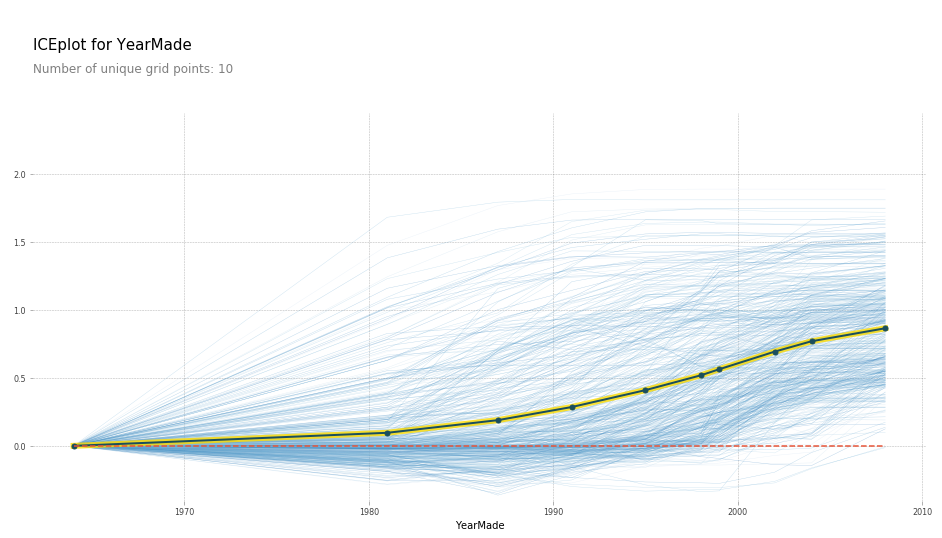

In [23]:
plot_pdp('YearMade')

We can also use cluster analysis with **pdp** to see if there's any relationship between the rows.

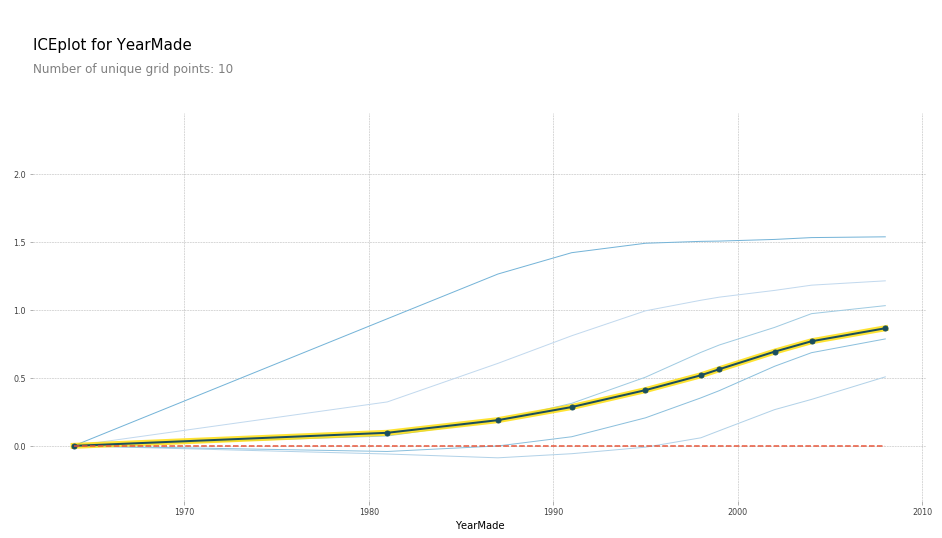

In [24]:
plot_pdp('YearMade', clusters=5)

**PDP interaction plot**

We can see how `saleElapsed` and `YearMade`, together impact `SalePrice`.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

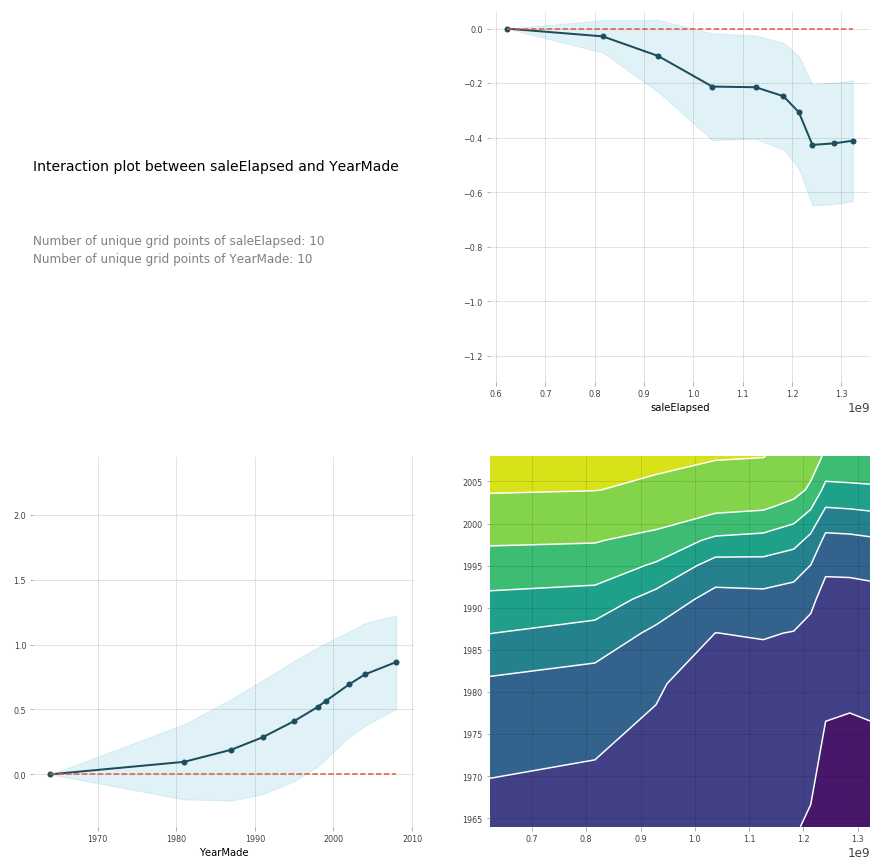

In [25]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

The plot on the left and top are univariante analyses, of `YearMade` and `saleElapsed` vs `SalePrice`. The 3rd plot is of both vaariables vs price.

Where you have one-hot encoded values, you can pass them as a list to `plot_pdp` and it will treat them as a category.

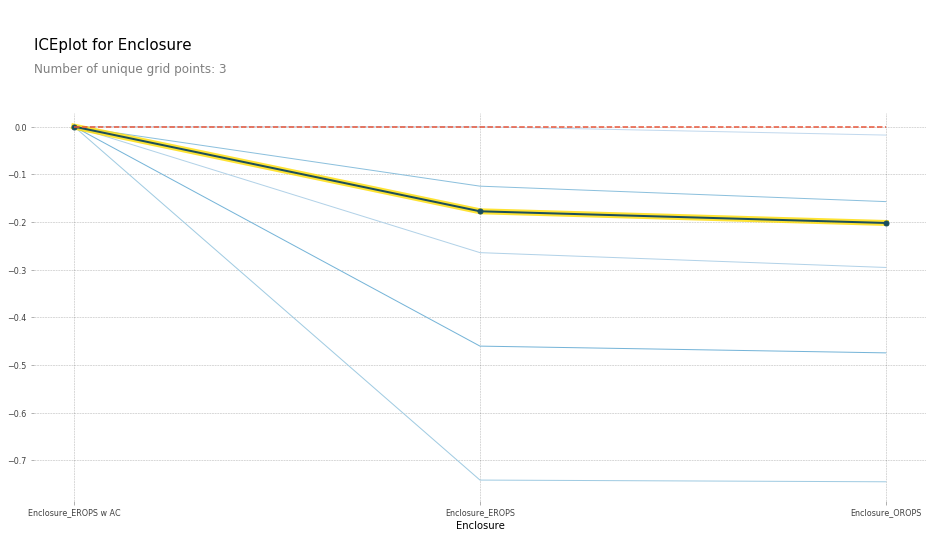

In [26]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

This plot shows that a bulldozer with an enclosure that contains air conditioning will sell for more than one that has an enclosure but no air conditioning, all other things being equal.

In [27]:
# replace previous yr values
df_raw.YearMade[df_raw.YearMade < 1950] = 1950 
# create a new 'age' feature
df_keep['age'] = df_raw['age'] = df_raw.saleYear - df_raw.YearMade

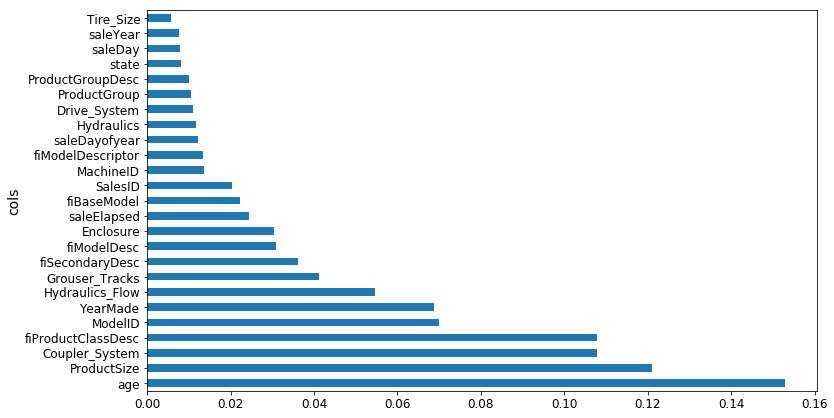

In [28]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

We can see now that age is the single most important feature.

# Tree interpreter

In [29]:
from treeinterpreter import treeinterpreter as ti

In [30]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [31]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 0,          1,       3232,    4364751,       1111,       2010,          0,    2300944,
                 4,          0,         12,          4,          0,         16,         35,        259,
                11]])

Call `.prediction` passing in your trained model and a specific row from the dataset.

In [32]:
prediction, bias, contributions = ti.predict(m, row)

It retruns the predicted `SalePrice`, the bias which is the average sale price across the whole dataset and the contributions. The is a list showing the value (or contribution) that each feature makes to the predicted value - it's the average of the contribution that the feature makes across all trees. 

In [33]:
prediction[0], bias[0]

(array([9.3546]), 10.104280471001113)

In [34]:
idxs = np.argsort(contributions[0])

In [35]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5109313688795399),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.15010718786983426),
 ('age', 11, -0.11241755961707112),
 ('fiModelDesc', 'KX1212', -0.050623612389061635),
 ('fiSecondaryDesc', nan, -0.047789964656753),
 ('fiBaseModel', 'KX121', -0.04050548971897818),
 ('saleYear', 2010, -0.015621075957825381),
 ('fiModelDescriptor', nan, -0.014966052359298621),
 ('Tire_Size', nan, -0.013923331043614828),
 ('Enclosure', 'EROPS', -0.01381964330606853),
 ('SalesID', 4364751, -0.007050191584811127),
 ('state', 'Ohio', -0.00665608482520037),
 ('saleDayofyear', 259, -0.005593697654051511),
 ('ProductGroupDesc', 'Track Excavators', 0.00197163250622987),
 ('saleDay', 16, 0.0024247098513802356),
 ('saleElapsed', 1284595200, 0.006276192816619952),
 ('MachineID', 2300944, 0.008222432294772864),
 ('Drive_System', nan, 0.010374897414263673),
 ('Hydraulics', 'Standard', 0.012241475178861982),
 ('ModelID', 665, 0.014510784677193023),

In [36]:
contributions[0].sum()

-0.7496823312100749

# Extrapolation

In [37]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [38]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

In [39]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.787331
5,saleElapsed,0.116926
13,saleYear,0.042836
15,MachineID,0.030711
23,saleDayofyear,0.012638
4,ModelID,0.001997
0,YearMade,0.001989
10,fiModelDesc,0.001855
12,fiBaseModel,0.001417
1,Coupler_System,0.000654


In [40]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [41]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [42]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [43]:
x.drop(feats, axis=1, inplace=True)

In [44]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.985637893424743

In [45]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,saleYear,0.306323
20,saleDayofyear,0.264809
4,ModelID,0.057231
18,saleDay,0.047385
19,state,0.040238
9,fiModelDesc,0.039431
0,YearMade,0.036736
21,age,0.032702
10,fiBaseModel,0.031699
8,Enclosure,0.025513


In [46]:
set_rf_samples(50000)

In [47]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [48]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.206293197284597, 0.24528759886565157, 0.911058461007824, 0.8925517967032063, 0.8947370895806035]


In [49]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.207624722108148, 0.24366857962363042, 0.9099066046552602, 0.8939655379292801, 0.8936944139156585]
saleElapsed
[0.20891973356869756, 0.24826643883593583, 0.9087792260307447, 0.8899261888919016, 0.892251225821798]
MachineID
[0.20505234461049326, 0.24190842689053058, 0.9121252090191383, 0.8954918960505037, 0.8965338607459576]
age
[0.20713118571807562, 0.24627666070271445, 0.9103344103753465, 0.8916835328568615, 0.893898809037965]
YearMade
[0.20655532384448308, 0.24649524679345505, 0.9108322901801968, 0.8914911721172715, 0.8945052349840399]
saleDayofyear
[0.2072479797299184, 0.24304439983845563, 0.9102332633036407, 0.8945080764780581, 0.8941146650454743]


In [50]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)